In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder

sns.set_style('darkgrid')
%matplotlib inline

In [53]:
_RANDOM_SEED = 2017

In [54]:
data = pd.read_csv('./data_with_features.csv')

## Apply one-hot encoding on the binned variables

In [55]:
data = pd.get_dummies(data, prefix='zip4', columns=['SitusZip_4digits'])
data = pd.get_dummies(data, prefix='zip3', columns=['SitusZip_3digits'])
data = pd.get_dummies(data, prefix='zip2', columns=['SitusZip_2digits'])
data = pd.get_dummies(data, prefix='square_footage_bin', columns=['SquareFootage_binned'])
data = pd.get_dummies(data, prefix='year_built_bin', columns=['YearBuilt_binned'])

## Split into Train and Holdout

In [56]:
train, validate = model_selection.train_test_split(data, 
                                               test_size=0.2, 
                                               train_size=0.8, 
                                               stratify=data['y'], 
                                               random_state=_RANDOM_SEED)

In [57]:
train = train.reset_index(drop=True)
validate = validate.reset_index(drop=True)

## Split Train into k-folds

In [58]:
kfolds = model_selection.StratifiedKFold(n_splits=5, random_state=_RANDOM_SEED)
kfolds.get_n_splits(X=train, y=data['y'])

5

In [59]:
data_cols = data.columns.tolist()

In [61]:
zip4_cols = [x for x in data_cols if 'zip4_' in x]
zip3_cols = [x for x in data_cols if 'zip3_' in x]
zip2_cols = [x for x in data_cols if 'zip2_' in x]
sqft_cols = [x for x in data_cols if 'square_footage_bin_' in x]
year_built_cols = [x for x in data_cols if 'year_built_bin_' in x]

In [62]:
original_features = ['SitusZip',
 'Bathrooms',
 'SquareFootage',
 'LotSize',
 'YearBuilt',
 'TaxAmount',
 'MarketValue',
 'TaxExemptionAmountHomeowner',
 'EstimatedValue',
 'NumberOfStories',
 'MarketImprovementPercent',
 'MarketImprovementValue',
 'MarketLandValue',
 'var_x',
 'vacant']

In [72]:
features = zip3_cols + sqft_cols + year_built_cols + ['vacant', 'Bathrooms_cap', 'NumberOfStories',
                                    'estimated_minus_market_cap', 
                                    'LotSize_cap', 'MarketImprovementPercent_sqd', 
                                    'has_tax_exemption', 'EstimatedValue_cap', 
                                    'TaxAmount_cap', 'MarketValue_cap', 'MarketLandValue', 
                                                      'MarketImprovementValue_cap']

In [10]:
data.columns.tolist()

['PID',
 'SitusZip',
 'Bathrooms',
 'SquareFootage',
 'LotSize',
 'YearBuilt',
 'TaxAmount',
 'MarketValue',
 'TaxExemptionAmountHomeowner',
 'EstimatedValue',
 'NumberOfStories',
 'MarketImprovementPercent',
 'MarketImprovementValue',
 'MarketLandValue',
 'var_x',
 'vacant',
 'y',
 'Bathrooms_cap',
 'has_tax_exemption',
 'LotSize_cap',
 'YearBuilt_cap',
 'YearBuilt_binned',
 'MarketValue_cap',
 'TaxAmount_cap',
 'EstimatedValue_cap',
 'estimated_minus_market',
 'estimated_minus_market_cap',
 'MarketImprovementPercent_cap',
 'MarketImprovementPercent_sqd',
 'MarketImprovementValue_cap',
 'MarketLandValue_cap',
 'zip4_7657',
 'zip4_7861',
 'zip4_7862',
 'zip4_7863',
 'zip4_7864',
 'zip4_7865',
 'zip4_7866',
 'zip4_7870',
 'zip4_7871',
 'zip4_7872',
 'zip4_7873',
 'zip4_7874',
 'zip4_7875',
 'zip3_765',
 'zip3_786',
 'zip3_787',
 'zip2_76',
 'zip2_78',
 'square_footage_bin_1',
 'square_footage_bin_2',
 'square_footage_bin_3',
 'square_footage_bin_4',
 'square_footage_bin_5',
 'square_foo

In [73]:
def fit_model(train_data, test_data, features, response='y'):
    model = LogisticRegression(penalty='l2', 
                           random_state=_RANDOM_SEED, 
                           C=.50,
                           class_weight='balanced', 
                           verbose=0)
    model = model.fit(X=train[features], y=train[response])
    test_data['pred_'] = model.predict_proba(X=test_data[features])[:, 1]
    train_data['pred_'] = model.predict_proba(X=train_data[features])[:, 1]
    test_auc = roc_auc_score(y_true=test_data['y'], y_score=test_data['pred_'])
    train_auc = roc_auc_score(y_true=train_data['y'], y_score=train_data['pred_'])
    return test_auc, train_auc

In [74]:
def fit_cv_models(kfolds, train, features, response='y'):
    test_aucs = []
    train_aucs = []
    for train_indexes, test_indexes in kfolds.split(X=train, y=train[response]):
        test_auc, train_auc = fit_model(train.ix[train_indexes], 
                                        train.ix[test_indexes], features=features)
        print('test_auc: {}\t train_auc: {}'.format(test_auc, train_auc))
        test_aucs.append(test_auc)
        train_aucs.append(train_auc)
    return np.mean(test_aucs), np.mean(train_aucs)

In [75]:
fit_cv_models(kfolds, train, features=features)

test_auc: 0.5665149043493753	 train_auc: 0.5616743127225932
test_auc: 0.5572316996389397	 train_auc: 0.5639909673851743
test_auc: 0.5605841012879761	 train_auc: 0.5631772024097988
test_auc: 0.5630478831582949	 train_auc: 0.5625622946085318
test_auc: 0.5663571255842433	 train_auc: 0.5617742447472083


(0.56274714280376592, 0.5626358043746611)

In [76]:
model = LogisticRegression(penalty='l2', 
                           random_state=_RANDOM_SEED, 
                           C=1.0,
                           class_weight='balanced', 
                           verbose=1)

In [77]:
non_feature_cols = ['y', 'PID', 'SitusZip', 'MarketImprovementPercent_cap', 'estimated_minus_market', 'MarketValue', 'EstimatedValue',
                    'SitusZip_4digits', 'class_weight', 'var_x']
#features = [x for x in data.columns.tolist() if x not in non_feature_cols]
response = 'y'
model = model.fit(X=train[features], y=train[response])

[LibLinear]

In [78]:
validate['pred_1'] = model.predict_proba(X=validate[features])[:, 1]
train['pred_1'] = model.predict_proba(X=train[features])[:, 1]

In [79]:
roc_auc_score(y_true=train['y'], y_score=train['pred_1'])

0.56268502755044814

In [80]:
roc_auc_score(y_true=validate['y'], y_score=validate['pred_1'])

0.53712361954784604

In [81]:
fpr, tpr, thresholds = roc_curve(y_true=validate['y'],
                                 y_score=validate['pred_1'])

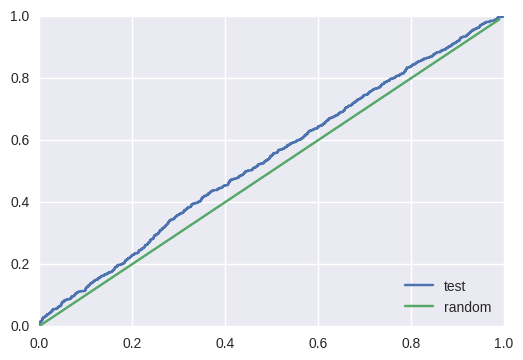

In [82]:
plt.figure()
plt.plot(fpr, tpr, label='test')
x = np.arange(0, 1.0, 0.01)
plt.plot(x, x, label='random')
plt.legend(loc='lower right')